In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

/var/folders/gg/gm8xvt3d6nq5bgsl60gj3q_80000gn/T/ipykernel_82587/1220833856.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import os, math

In [4]:
def plot(algos, regrets, cumsum=False, filename=None, figshow=True, legendloc='bottom left', tick_spacing=200, test_freq=10):
    assert len(algos) == len(regrets)
    num_algos = len(algos)
    
    # Get color range
    cmap = plt.cm.get_cmap('jet')
    colors = cmap(np.arange(cmap.N))
    cinv = cmap.N / (1. * num_algos) 
    
    
    if cumsum:
        regrets_ = []
        for r in regrets:
            regrets_.append(r.cumsum(axis=1))
        regrets = regrets_
    
    # Compute mu and std 
    mus = []
    stds = []
    for r in regrets:
        mu = np.mean(r,axis=0)
        std = np.std(r,axis=0) / math.sqrt(r.shape[0])
        mus.append(mu)
        stds.append(std) 
        
    # Plot 
    T = regrets[0].shape[1]
    fig = plt.figure(figsize=(5,4))
    dom = np.arange(T)

    for i in range(num_algos):
        color = colors[int( (i + 0.5) * cinv)] 
        plt.plot(dom, mus[i], label=algos[i], color=color) 
        plt.fill_between(dom, mus[i] + 1.96 * stds[i],\
                         mus[i] - 1.96 * stds[i], alpha=0.2, color=color)

    plt.xlim([0,T])
    plt.rc('grid', linestyle='--', color='black', alpha=0.2)
    plt.grid('on')
    
    if legendloc:
        plt.legend(loc = legendloc, prop={'size': 11}) 
    else:
        plt.legend(prop={'size':11})


    dom = np.arange(0, T, tick_spacing)
    # print('T = {}'.format(T))
    plt.xticks(dom, dom*test_freq)
    plt.xlabel('Number of samples',fontsize=12)
    plt.ylabel('Sub-optimality',fontsize=12)

    if filename:
        if not os.path.exists('fig'):
            os.makedirs('fig')
        fig.savefig(os.path.join('fig', filename), dpi=500, bbox_inches='tight')
    
    if not figshow:
        plt.close(fig)
        plt.clf()

['regrets', 'errs']
{'regrets': array([[[0.05 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
         0.01 , 0.01 , 0.01 , 0.01 , 0.012, 0.011, 0.016, 0.902, 0.745,
         0.86 , 0.843, 0.073, 0.223, 0.125, 0.048, 0.05 , 0.048, 0.972,
         0.899, 0.042, 0.397, 0.022, 0.02 , 0.017, 0.019, 0.934, 0.92 ,
         0.036, 0.05 , 0.028, 0.943, 0.938, 0.203, 0.623, 0.047, 0.028,
         0.015, 0.425, 0.274, 0.236, 0.081, 0.036, 0.356, 0.077, 0.12 ,
         0.031, 0.027, 0.031, 0.024, 0.09 , 0.701, 0.05 , 0.046, 0.046,
         0.581, 0.537, 0.05 , 0.04 , 0.038, 0.619, 0.029, 0.03 , 0.028,
         0.028, 0.024, 0.045, 0.035, 0.029, 0.034, 0.015, 0.038, 0.033,
         0.034, 0.026, 0.067, 0.044, 0.035, 0.043, 0.031, 0.034, 0.033,
         0.03 , 0.042, 0.033, 0.028, 0.026, 0.027, 0.048, 0.042, 0.031,
         0.044, 0.026, 0.034, 0.033, 0.029, 0.041, 0.032, 0.034, 0.033,
         0.034, 0.032, 0.037, 0.038, 0.032, 0.032, 0.032, 0.045, 0.029,
         0.023, 0.044, 0.022, 0.

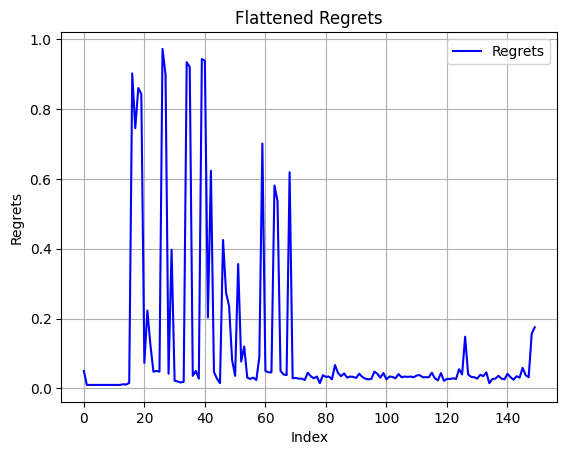

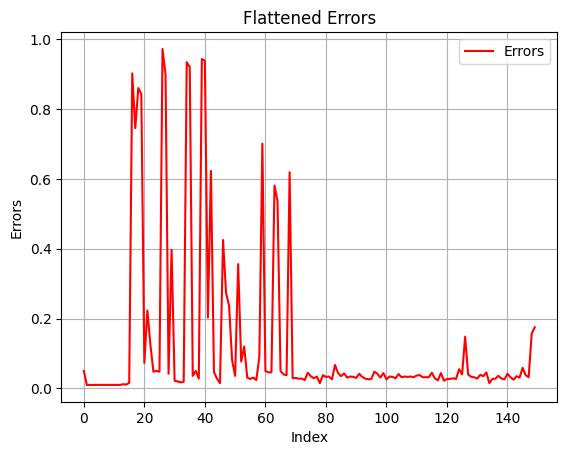

In [6]:
# def plot_sepsis_bmode():
sepsis_path = './results/sepsis_d=13_a=2_pi=eps-greedy0.1_std=0.01'
approx_neural_path = 'approx-neural-gridsearch_epochs=100_m=100_layern=True_buffer=-1_bs=32_lr=0.001_beta=0.1_lambda=0.0001_lambda0=0.1.npz'
data= np.load(os.path.join(sepsis_path,approx_neural_path)) 

regrets = data['regrets']
errs = data['errs']

# If you want to see all the arrays' names

print(data.files)

# Optionally, convert to a dictionary for easier access (optional)
data_dict = dict(data)
print(data_dict)


print("Regrets shape:", regrets.shape)
print("Errors shape:", errs.shape)

regrets_flat = regrets.flatten()
errs_flat = errs.flatten()

plt.plot(regrets_flat, label='Regrets', color='blue')
plt.title('Flattened Regrets')
plt.xlabel('Index')
plt.ylabel('Regrets')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(errs_flat, label='Errors', color='red')
plt.title('Flattened Errors')
plt.xlabel('Index')
plt.ylabel('Errors')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
def plot_realworld_experiment(name, trainconfig, beta, rbf_sigma, lr=0.001, figshow=False, legendloc=None, save=True, tick_spacing=200, test_freq=10, policy='eps-greedy'):
    res_dir = os.path.join('results', name)
    approx_neural = 'approx-neural-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_beta={}_lambda=0.0001_lambda0=0.1.npz'.format(trainconfig[0],trainconfig[1],trainconfig[2],lr,beta)
    neural_greedy = 'neural-greedy-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_lambda=0.0001.npz'.format(trainconfig[0],trainconfig[1],trainconfig[2],lr)
    baseline = 'baseline_epochs=100_m=100_layern=True_beta=0.1_lambda0=0.1_rbf-sigma=1.0_maxnum=1000.npz'
    kern = 'kern-gridsearch_beta=0.1_rbf-sigma={}_maxnum=1000.npz'.format(rbf_sigma)

    neuralcb = np.load(os.path.join(res_dir,approx_neural))['arr_0']
    neuralgreedy = np.load(os.path.join(res_dir,neural_greedy))['arr_0']
    bl = np.load(os.path.join(res_dir,baseline))['arr_0']
    kernlcb = np.load(os.path.join(res_dir,kern))['arr_0']

    # Read data 
    arrs = (neuralcb, neuralgreedy, bl, kernlcb) 
    algos = ['NeuraLCB', 'NeuralGreedy', 'LinLCB', 'NeuralLinLCB', 'NeuralLinGreedy', 'KernLCB']
    algos = ['NeuraLCB', 'NeuralGreedy', 'LinLCB', 'NeuralLinLCB', 'NeuralLinGreedy', 'KernLCB']
    regrets = [] 
    i = 0
    for a in arrs:
        for i in range(1,a.shape[1]):
            regrets.append(a[:,i,:])

    # Plot
    filename = '{}_{}_cf={}{}{}_beta={}_lr={}_rbfsigma={}.pdf'.format(policy,name.split('_')[0],trainconfig[0],trainconfig[1],trainconfig[2],beta,lr,rbf_sigma)
    print(filename)
    plot(algos, regrets, cumsum=False, filename=filename if save else None, figshow=figshow, legendloc=legendloc, tick_spacing=tick_spacing, test_freq=test_freq)

## Plot everything

In [14]:
policy = 'online'
data_types = [
             #'mushroom_d=117_a=2_pi={}0.1_std=0'.format(policy),
              'statlog_d=10_a=7_pi={}0.1_std=0'.format(policy),
              #'stock_d=21_a=8_pi=eps-greedy0.1_std=0.1',
              #'jester_d=32_a=8_pi=eps-greedy0.1_std=0.1', 
              #'covertype_d=54_a=7_pi=eps-greedy0.1_std=0', 
              #'census_d=387_a=9_pi=eps-greedy0.1_std=0.0',
              'adult_d=92_a=14_pi={}0.1_std=0.0'.format(policy),
            'mnist_d=784_a=10_pi={}0.1_std=0'.format(policy)    
            ]

betas = [0.01,0.05,1.0,5.0, 10.0]
trconfigs =  [(1,1,1),(100,-1,50)]
rbf_sigmas = [0.1,1.0,10.0]
lrs = [0.001,0.0001]
for data_type in data_types:
    if data_type.split('_')[0] == 'mnist':
        test_freq = 100 
        tick_spacing = 20 
    else:
        test_freq = 10 
        tick_spacing = 200
    for trconfig in trconfigs:
        for beta in betas:
            for lr in lrs:
                for rbf_sigma in rbf_sigmas:
                    try:
                        plot_realworld_experiment(data_type, trconfig, beta, rbf_sigma, lr, tick_spacing=tick_spacing,test_freq=test_freq, policy=policy)
                    except: 
                        fname =  'online_{}_cf={}{}{}_beta={}_lr={}_rbfsigma={}.pdf'.format(data_type.split('_')[0],trconfig[0],trconfig[1],trconfig[2],beta,lr,rbf_sigma)
                        print('Not found {}'.format(fname))

Not found online_statlog_cf=111_beta=0.01_lr=0.001_rbfsigma=0.1.pdf
Not found online_statlog_cf=111_beta=0.01_lr=0.001_rbfsigma=1.0.pdf
Not found online_statlog_cf=111_beta=0.01_lr=0.001_rbfsigma=10.0.pdf
Not found online_statlog_cf=111_beta=0.01_lr=0.0001_rbfsigma=0.1.pdf
Not found online_statlog_cf=111_beta=0.01_lr=0.0001_rbfsigma=1.0.pdf
Not found online_statlog_cf=111_beta=0.01_lr=0.0001_rbfsigma=10.0.pdf
Not found online_statlog_cf=111_beta=0.05_lr=0.001_rbfsigma=0.1.pdf
Not found online_statlog_cf=111_beta=0.05_lr=0.001_rbfsigma=1.0.pdf
Not found online_statlog_cf=111_beta=0.05_lr=0.001_rbfsigma=10.0.pdf
Not found online_statlog_cf=111_beta=0.05_lr=0.0001_rbfsigma=0.1.pdf
Not found online_statlog_cf=111_beta=0.05_lr=0.0001_rbfsigma=1.0.pdf
Not found online_statlog_cf=111_beta=0.05_lr=0.0001_rbfsigma=10.0.pdf
Not found online_statlog_cf=111_beta=1.0_lr=0.001_rbfsigma=0.1.pdf
Not found online_statlog_cf=111_beta=1.0_lr=0.001_rbfsigma=1.0.pdf
Not found online_statlog_cf=111_beta=1.0

In [15]:
plot_realworld_experiment(data_type, trconfig, beta, rbf_sigma, lr,tick_spacing=20, test_freq=test_freq, figshow=True,save=False)

FileNotFoundError: [Errno 2] No such file or directory: 'results\\mnist_d=784_a=10_pi=online0.1_std=0\\approx-neural-gridsearch_epochs=100_m=100_layern=True_buffer=-1_bs=50_lr=0.0001_beta=10.0_lambda=0.0001_lambda0=0.1.npz'

## Plot S-mode vs B-mode 

In [6]:
def plot_smode_vs_bmode(name, beta, lr=0.001, figshow=False, legendloc=None, save=True, tick_spacing=200, test_freq=10, policy='eps-greedy'):
    res_dir = os.path.join('results', name)
    smode = (1,1,1)
    bmode = (100,-1,50)
    approx_neural_smode = 'approx-neural-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_beta={}_lambda=0.0001_lambda0=0.1.npz'.format(smode[0],smode[1],smode[2],lr,beta)    
    approx_neural_bmode = 'approx-neural-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_beta={}_lambda=0.0001_lambda0=0.1.npz'.format(bmode[0],bmode[1],bmode[2],lr,beta)
    
    neural_greedy_smode = 'neural-greedy-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_lambda=0.0001.npz'.format(smode[0],smode[1],smode[2],lr)
    neural_greedy_bmode = 'neural-greedy-gridsearch_epochs={}_m=100_layern=True_buffer={}_bs={}_lr={}_lambda=0.0001.npz'.format(bmode[0],bmode[1],bmode[2],lr)


    neuralcb_s = np.load(os.path.join(res_dir,approx_neural_smode))['arr_0']
    neuralcb_b = np.load(os.path.join(res_dir,approx_neural_bmode))['arr_0']
    
    
    neuralgreedy_s = np.load(os.path.join(res_dir,neural_greedy_smode))['arr_0']
    neuralgreedy_b = np.load(os.path.join(res_dir,neural_greedy_bmode))['arr_0']


    # Read data 
    arrs = (neuralcb_s, neuralcb_b, neuralgreedy_s, neuralgreedy_b)
    algos = ['NeuraLCB(S-mode)', 'NeuraLCB(B-mode)', 'NeuralGreedy(S-mode)', 'NeuralGreedy(B-mode)']
    regrets = [] 
    i = 0
    for a in arrs:
        for i in range(1,a.shape[1]):
            regrets.append(a[:,i,:])

    # Plot
    filename = 'mode_{}_beta={}_lr={}_policy={}.pdf'.format(name.split('_')[0],beta,lr, policy)
    print(filename)
    plot(algos, regrets, cumsum=False, filename=filename if save else None, figshow=figshow, legendloc=legendloc, tick_spacing=tick_spacing, test_freq=test_freq)

In [7]:
data_types = [
            #  'mushroom_d=117_a=2_pi=eps-greedy0.1_std=0',
            #   'statlog_d=10_a=7_pi=eps-greedy0.1_std=0',
              
              'sepsis_d=13_a=2_pi=eps-greedy0.1_std=0.01'
              

              #'stock_d=21_a=8_pi=eps-greedy0.1_std=0.1',
              #'jester_d=32_a=8_pi=eps-greedy0.1_std=0.1', 
              #'covertype_d=54_a=7_pi=eps-greedy0.1_std=0', 
              #'census_d=387_a=9_pi=eps-greedy0.1_std=0.0',
#               'adult_d=92_a=14_pi=eps-greedy0.1_std=0.0',
#             'mnist_d=784_a=10_pi=eps-greedy0.1_std=0'    
            ]
policy='eps-greedy'
test_freq = 10 # for mnist
tick_spacing = 200  # mnist, 200 for other data
betas = [0.01,0.05,1.0,5.0, 10.0]
# lrs = [0.001,0.0001]
lrs = [0.0001]
for data_type in data_types:
    if data_type.split('_') == 'mnist':
        test_freq = 100 
        tick_spacing=20
    for beta in betas:
        for lr in lrs:
            #try:
            plot_smode_vs_bmode(data_type, beta, lr, tick_spacing=tick_spacing,test_freq=test_freq,policy=policy)
            #except: 
            #    fname =  '{}_beta={}_lr={}.pdf'.format(data_type.split('_')[0],beta,lr)
            #    print('Not found {}'.format(fname))

FileNotFoundError: [Errno 2] No such file or directory: 'results\\mushroom_d=117_a=2_pi=eps-greedy0.1_std=0\\approx-neural-gridsearch_epochs=1_m=100_layern=True_buffer=1_bs=1_lr=0.001_beta=0.01_lambda=0.0001_lambda0=0.1.npz'